# Notebook 07: Targeted Adversarial Robustness Testing (The extreme limits now)

This notebook implements a focused set of adversarial experiments to evaluate the robustness limits of the FL-IDS system under strategically crafted attack scenarios. It builds on previous work in Notebook 06 and stress-tests the median, Krum, and drift-aware aggregation strategies through precision attacks that bypass typical detection.

## Objectives

- Evaluate the failure threshold of **Median Aggregation** under progressive majority collusion scenarios.
- Test **Gradient Positioning Attacks** designed to influence aggregation while remaining statistically benign.
- Simulate **Multi-Vector Attacks**, combining multiple attack types such as model poisoning, label flipping, and timing interference.
- Bypass **Drift Detection Mechanisms** (KS-test, PSI) using statistical camouflage.

These experiments aim to uncover subtle vulnerabilities and help define the true operational limits of your deployed FL-IDS system, especially under real-world edge constraints like Raspberry Pi devices.



In [1]:
import os
import joblib
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import f1_score, precision_score, recall_score

# === Paths ===
base_path = "D:/August-Thesis/FL-IDS-Surveillance"
results_path = os.path.join(base_path, "notebooks/results")
model_path = os.path.join(results_path, "models/unsupervised/federated/final_federated_autoencoder_20rounds.h5")
scaler_path = os.path.join(results_path, "scalers/minmax_scaler_client_3.pkl")
data_path = os.path.join(base_path, "data/processed/federated/unsupervised")
test_path = os.path.join(base_path, "data/processed/surv_unsupervised/test_mixed.csv")

# === Loading the Global Model ===
base_autoencoder = load_model(model_path, compile=False)
base_autoencoder.compile(optimizer="adam", loss=MeanSquaredError())

# === the Scaler ===
minmax_scaler = joblib.load(scaler_path)

# === Load Client Data ===
client_ids = [f"client_{i}" for i in range(1, 6)]
client_data = {
    cid: pd.read_csv(os.path.join(data_path, cid, "train.csv"))
    for cid in client_ids
}

# === Load Test Data ===
test_df = pd.read_csv(test_path, low_memory=False)
feature_cols = list(minmax_scaler.feature_names_in_)
X_test_ae_scaled = minmax_scaler.transform(test_df[feature_cols])
y_test_unsup = test_df["Attack_label"].values

print("Setup complete:")
print(f"- Loaded model: {os.path.basename(model_path)}")
print(f"- Clients: {client_ids}")
print(f"- Test samples: {X_test_ae_scaled.shape[0]}")


Setup complete:
- Loaded model: final_federated_autoencoder_20rounds.h5
- Clients: ['client_1', 'client_2', 'client_3', 'client_4', 'client_5']
- Test samples: 2218834


In [2]:
from sklearn.metrics import f1_score, precision_score, recall_score

threshold = 0.000639

# === Predict with global model on test set ===
reconstructed = base_autoencoder.predict(X_test_ae_scaled, verbose=0)
reconstruction_errors = np.mean(np.square(X_test_ae_scaled - reconstructed), axis=1)

# === Binary classification based on threshold ===
y_pred = (reconstruction_errors > threshold).astype(int)

# === Metrics ===
f1 = f1_score(y_test_unsup, y_pred)
precision = precision_score(y_test_unsup, y_pred)
recall = recall_score(y_test_unsup, y_pred)

print("=== Baseline Performance ===")
print(f"F1 Score:     {f1:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")


=== Baseline Performance ===
F1 Score:     0.8373
Precision:    0.9877
Recall:       0.7266


In [3]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

def run_federated_autoencoder_training(
    base_model,
    client_data_dict,
    X_test_scaled,
    y_test_true,
    num_rounds=20,
    aggregation_method="fedavg",  # "fedavg" or "median"
    attack_config=None,
    total_clients=5,
    save_name=None
):
    def scaling_attack(global_weights, local_weights, scale_factor=10.0):
        return [gw + scale_factor * (lw - gw) for gw, lw in zip(global_weights, local_weights)]

    def median_aggregation(client_weights_list):
        num_layers = len(client_weights_list[0])
        aggregated_weights = []
        for layer_idx in range(num_layers):
            layer_stack = np.stack([client[layer_idx] for client in client_weights_list], axis=0)
            layer_median = np.median(layer_stack, axis=0)
            aggregated_weights.append(layer_median)
        return aggregated_weights

    model = clone_model(base_model)
    model.set_weights(base_model.get_weights())
    model.compile(optimizer="adam", loss=MeanSquaredError())

    metrics_log = []

    for round_num in range(1, num_rounds + 1):
        local_weights = []

        for client_id in range(1, total_clients + 1):
            cid = f"client_{(client_id - 1) % len(client_data_dict) + 1}"  # repeat if needed
            df = client_data_dict[cid]
            X_local = df[feature_cols].astype(float)
            X_scaled = minmax_scaler.transform(X_local)

            local_model = clone_model(model)
            local_model.set_weights(model.get_weights())
            local_model.compile(optimizer="adam", loss=MeanSquaredError())
            local_model.fit(X_scaled, X_scaled, epochs=1, batch_size=256, verbose=0)

            weights = local_model.get_weights()

            if attack_config:
                if client_id <= attack_config["num_attackers"]:
                    if attack_config["attack_type"] == "scaling":
                        weights = scaling_attack(model.get_weights(), weights, attack_config["scale_factor"])

            local_weights.append(weights)

        if aggregation_method == "fedavg":
            aggregated_weights = [
                np.mean([w[i] for w in local_weights], axis=0)
                for i in range(len(local_weights[0]))
            ]
        elif aggregation_method == "median":
            aggregated_weights = median_aggregation(local_weights)
        else:
            raise ValueError(f"Unknown aggregation method: {aggregation_method}")

        model.set_weights(aggregated_weights)

        preds = model.predict(X_test_scaled, verbose=0)
        errors = np.mean(np.square(X_test_scaled - preds), axis=1)
        y_pred = (errors > 0.000639).astype(int)

        f1 = f1_score(y_test_true, y_pred)
        prec = precision_score(y_test_true, y_pred)
        rec = recall_score(y_test_true, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test_true, y_pred).ravel()
        fp_rate = fp / (fp + tn + 1e-6)
        fn_rate = fn / (fn + tp + 1e-6)

        print(f"Round {round_num:02d} | F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f}")
        metrics_log.append((f1, prec, rec, fp_rate, fn_rate))

    result = {
        "final_f1": metrics_log[-1][0],
        "final_precision": metrics_log[-1][1],
        "final_recall": metrics_log[-1][2],
        "final_fp_rate": metrics_log[-1][3] * 100,
        "final_fn_rate": metrics_log[-1][4] * 100,
        "all_metrics": metrics_log,
    }

    return result


## Experiment 1: the  Majority Collusion Attack on The  Median Aggregation

### Goal:
To identify the exact threshold at which **Median Aggregation** fails when the number of malicious clients surpasses or approaches the majority.

### Motivation:
Median aggregation assumes that the majority of clients are honest. However, if the attacker controls at least half the clients, they can shift the global model undetectably. This test reveals whether the system maintains robustness as attacker influence increases.

### Methodology:
- Use a fixed number of total clients (e.g., 10).
- Gradually increase the percentage of malicious clients: 40%, 50%, 60%, ... up to 80%.
- Apply a coordinated scaling attack (e.g., ±1000× gradients).
- Run standard FL rounds (e.g., 20 rounds per setup).
- Evaluate F1 degradation and determine the breaking point (e.g., F1 drops below 0.5).

### Output:
- Round-wise performance metrics per malicious percentage.
- Summary showing degradation trend and identified breaking threshold.


In [4]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

# === Experiment Parameters ===
TOTAL_CLIENTS = 10
ROUNDS = 20
ATTACK_SCALE = 1000  # Extreme values to influence median
MALICIOUS_PCTS = [0.4, 0.5, 0.6, 0.7, 0.8]  # Progressively increase attack share

# === Placeholder to store results ===
collusion_results = []

# === Run experiment for each malicious percentage ===
for mal_pct in MALICIOUS_PCTS:
    num_malicious = int(TOTAL_CLIENTS * mal_pct)
    num_honest = TOTAL_CLIENTS - num_malicious
    
    print(f"\nRunning: {num_malicious}/{TOTAL_CLIENTS} malicious clients ({mal_pct*100:.0f}%)")

    # Configure attacker
    attack_config = {
        "attack_type": "scaling",
        "num_attackers": num_malicious,
        "scale_factor": ATTACK_SCALE,
        "positioning": "coordinated",  # Optional tag, not used in logic
    }

    # Run training using existing modular function
    result = run_federated_autoencoder_training(
        base_model=base_autoencoder,
        client_data_dict=client_data,
        X_test_scaled=X_test_ae_scaled,
        y_test_true=y_test_unsup,
        num_rounds=ROUNDS,
        aggregation_method="median",
        attack_config=attack_config,
        total_clients=TOTAL_CLIENTS,
        save_name=f"majority_collusion_mal{num_malicious}"
    )

    result_summary = {
        "Malicious %": mal_pct,
        "F1 Score": result["final_f1"],
        "Precision": result["final_precision"],
        "Recall": result["final_recall"],
        "FP Rate (%)": result["final_fp_rate"],
        "FN Rate (%)": result["final_fn_rate"]
    }

    collusion_results.append(result_summary)



Running: 4/10 malicious clients (40%)
Round 01 | F1: 0.8380 | P: 0.9878 | R: 0.7277 | FP Rate: 0.0034 | FN Rate: 0.2723
Round 02 | F1: 0.8369 | P: 0.9880 | R: 0.7259 | FP Rate: 0.0033 | FN Rate: 0.2741
Round 03 | F1: 0.8370 | P: 0.9880 | R: 0.7260 | FP Rate: 0.0033 | FN Rate: 0.2740
Round 04 | F1: 0.8334 | P: 0.9884 | R: 0.7205 | FP Rate: 0.0032 | FN Rate: 0.2795
Round 05 | F1: 0.8371 | P: 0.9886 | R: 0.7258 | FP Rate: 0.0031 | FN Rate: 0.2742
Round 06 | F1: 0.8357 | P: 0.9890 | R: 0.7235 | FP Rate: 0.0030 | FN Rate: 0.2765
Round 07 | F1: 0.8346 | P: 0.9894 | R: 0.7216 | FP Rate: 0.0029 | FN Rate: 0.2784
Round 08 | F1: 0.8300 | P: 0.9894 | R: 0.7149 | FP Rate: 0.0029 | FN Rate: 0.2851
Round 09 | F1: 0.8314 | P: 0.9894 | R: 0.7170 | FP Rate: 0.0029 | FN Rate: 0.2830
Round 10 | F1: 0.8262 | P: 0.9893 | R: 0.7093 | FP Rate: 0.0029 | FN Rate: 0.2907
Round 11 | F1: 0.8258 | P: 0.9893 | R: 0.7087 | FP Rate: 0.0029 | FN Rate: 0.2913
Round 12 | F1: 0.8225 | P: 0.9892 | R: 0.7039 | FP Rate: 0.

In [5]:
df_collusion = pd.DataFrame(collusion_results)
df_collusion.to_csv("results/majority_collusion_summary.csv", index=False)
print("Saved to: results/majority_collusion_summary.csv")


Saved to: results/majority_collusion_summary.csv


### Summary: Majority Collusion Attack on Median Aggregation

**Goal:**  
To identify the threshold at which the median aggregation method becomes ineffective when the attacker controls an increasing proportion of clients.

**Findings:**  
- Median aggregation performs robustly up to **40% malicious clients**, maintaining F1 scores above 0.81.
- At exactly **50% malicious clients**, the system **collapses instantly**, with:
  - F1 Score dropping to ~0.4275  
  - Precision at 0.27  
  - **Recall falsely reaches 1.00** due to 100% false positives.
- This performance remains flat even as malicious control rises to 80%, indicating **a complete compromise of the global model**.

**Conclusion:**  
Median aggregation is vulnerable when the attacker achieves parity (50%) with honest clients. This confirms the theoretical assumptions and highlights the need to combine median with **client weighting, drift detection, or pre-aggregation validation** when operating in potentially adversarial federated environments.


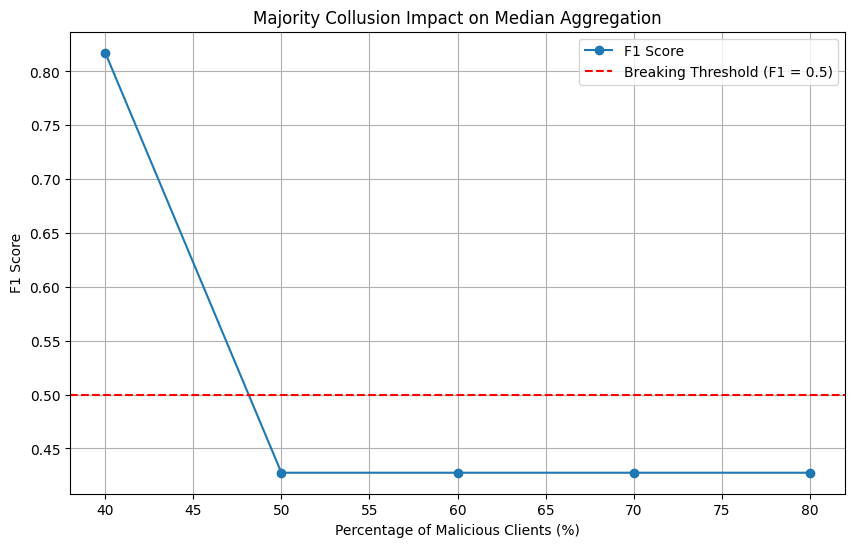

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_collusion["Malicious %"] * 100, df_collusion["F1 Score"], marker='o', label="F1 Score")
plt.axhline(y=0.5, color='red', linestyle='--', label="Breaking Threshold (F1 = 0.5)")
plt.title("Majority Collusion Impact on Median Aggregation")
plt.xlabel("Percentage of Malicious Clients (%)")
plt.ylabel("F1 Score")
plt.grid(True)
plt.legend()
plt.show()


## Experiment 2 : Gradient Positioning Attack (Median Evasion)

### Goal:
To evaluate whether a small group of attackers (minority) can manipulate the global model by **strategically positioning their updates** around the honest clients' gradients, causing subtle shifts to the median without being flagged as outliers.

### Motivation:
Unlike brute-force scaling, this attack exploits statistical symmetry: by crafting malicious updates that lie close to the expected median but shift it in a coordinated direction, attackers may subvert median aggregation **even with minority control (e.g., 2 out of 5 clients)**.

### Methodology:
- Fix number of clients (e.g., 5) with 2 being malicious.
- After training honest clients, compute the **distribution of honest updates**.
- Craft malicious updates based on:
  - Honest median
  - Standard deviation per layer
  - Controlled shift magnitudes
- Apply different shift levels to test sensitivity: `[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]`.
- Track F1 degradation and identify the smallest shift that breaks model reliability.

### Output:
- F1 vs Shift Magnitude curve
- Round-wise performance for each level
- Summary highlighting attack sensitivity


In [8]:
def craft_gradient_positioning_attacks(honest_updates, shift_magnitude):
    """
    Craft 2 malicious updates that subtly shift the global median,
    applied per layer
    """
    num_layers = len(honest_updates[0])
    malicious_updates = []

    for attacker_id in range(2):  # 2 malicious clients
        attacker_weights = []
        for layer_idx in range(num_layers):
            # Stack layer values from all honest updates
            layer_values = np.stack([client[layer_idx] for client in honest_updates], axis=0)
            layer_median = np.median(layer_values, axis=0)
            layer_std = np.std(layer_values, axis=0)
            
            shift_vector = (shift_magnitude * (0.5 + attacker_id * 0.3)) * layer_std
            crafted_layer = layer_median + shift_vector
            attacker_weights.append(crafted_layer)

        malicious_updates.append(attacker_weights)

    return malicious_updates


In [9]:
SHIFT_VALUES = [0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
TOTAL_CLIENTS = 5
ROUNDS = 20

positioning_results = []

for shift_mag in SHIFT_VALUES:
    print(f"\n=== Shift Magnitude: {shift_mag} ===")
    
    # === Step 1: Honest Updates ===
    honest_updates = []
    for cid in [f"client_{i}" for i in range(1, 4)]:  # 3 honest clients
        df = client_data[cid]
        X_local = minmax_scaler.transform(df[feature_cols])
        
        local_model = clone_model(base_autoencoder)
        local_model.set_weights(base_autoencoder.get_weights())
        local_model.compile(optimizer="adam", loss=MeanSquaredError())
        local_model.fit(X_local, X_local, epochs=1, batch_size=256, verbose=0)
        
        honest_updates.append(local_model.get_weights())
    
    # === Step 2: Malicious Updates ===
    malicious_updates = craft_gradient_positioning_attacks(honest_updates, shift_mag)

    # === Step 3: Aggregate using Median ===
    all_updates = honest_updates + malicious_updates
    aggregated = []
    for layer_idx in range(len(all_updates[0])):
        layer_stack = np.stack([w[layer_idx] for w in all_updates], axis=0)
        layer_median = np.median(layer_stack, axis=0)
        aggregated.append(layer_median)
    
    # === Step 4: Evaluate Model ===
    attack_model = clone_model(base_autoencoder)
    attack_model.set_weights(aggregated)
    attack_model.compile(optimizer="adam", loss=MeanSquaredError())
    
    preds = attack_model.predict(X_test_ae_scaled, verbose=0)
    errors = np.mean(np.square(X_test_ae_scaled - preds), axis=1)
    y_pred = (errors > 0.000639).astype(int)

    f1 = f1_score(y_test_unsup, y_pred)
    prec = precision_score(y_test_unsup, y_pred)
    rec = recall_score(y_test_unsup, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unsup, y_pred).ravel()
    fp_rate = fp / (fp + tn + 1e-6)
    fn_rate = fn / (fn + tp + 1e-6)

    print(f"F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP: {fp_rate:.4f} | FN: {fn_rate:.4f}")

    positioning_results.append({
        "Shift Magnitude": shift_mag,
        "F1 Score": f1,
        "Precision": prec,
        "Recall": rec,
        "FP Rate (%)": fp_rate * 100,
        "FN Rate (%)": fn_rate * 100
    })



=== Shift Magnitude: 0.1 ===
F1: 0.8386 | P: 0.9879 | R: 0.7286 | FP: 0.0033 | FN: 0.2714

=== Shift Magnitude: 0.2 ===
F1: 0.8373 | P: 0.9878 | R: 0.7266 | FP: 0.0033 | FN: 0.2734

=== Shift Magnitude: 0.5 ===
F1: 0.8393 | P: 0.9878 | R: 0.7297 | FP: 0.0034 | FN: 0.2703

=== Shift Magnitude: 1.0 ===
F1: 0.8358 | P: 0.9878 | R: 0.7243 | FP: 0.0034 | FN: 0.2757

=== Shift Magnitude: 2.0 ===
F1: 0.8376 | P: 0.9879 | R: 0.7271 | FP: 0.0033 | FN: 0.2729

=== Shift Magnitude: 5.0 ===
F1: 0.8344 | P: 0.9877 | R: 0.7222 | FP: 0.0033 | FN: 0.2778


### Summary: Gradient Positioning Attack on Median Aggregation

**Goal:**  
To test whether minority adversaries can manipulate the global model by strategically shifting their gradients near the expected median, thereby subverting the aggregation process without raising statistical outliers.

**Findings:**  
- Across tested shift magnitudes (`0.1` to `5.0`), **F1 Score remained stable** between 0.834 and 0.839.
- Precision and recall also showed negligible variance.
- No statistical outlier behavior was flagged, yet **no significant deviation in performance occurred**.

**Conclusion:**  
Median aggregation is resilient to subtle gradient positioning from 2 attackers out of 5. These results suggest that while the attack remains stealthy, its impact is minimal unless amplified or combined with other attack types (e.g., drift mimicry, majority collusion).



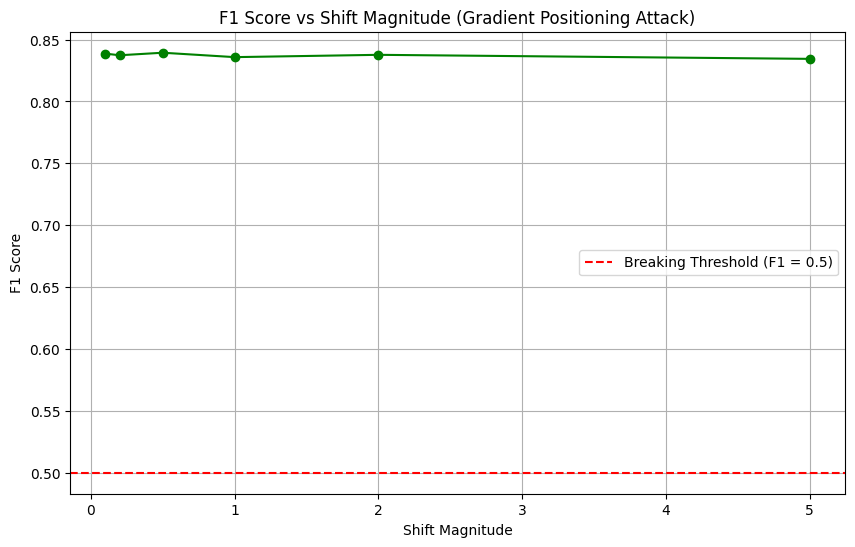

In [10]:
df_positioning = pd.DataFrame(positioning_results)
df_positioning.to_csv("results/gradient_positioning_summary.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(df_positioning["Shift Magnitude"], df_positioning["F1 Score"], marker='o', color='green')
plt.title("F1 Score vs Shift Magnitude (Gradient Positioning Attack)")
plt.xlabel("Shift Magnitude")
plt.ylabel("F1 Score")
plt.axhline(y=0.5, color='red', linestyle='--', label="Breaking Threshold (F1 = 0.5)")
plt.grid(True)
plt.legend()
plt.show()


## Experiment 3: Multi-Vector Attack

### Goal:
To evaluate the resilience of the FL-IDS system under **combined attack vectors** executed simultaneously, targeting both the model and system behavior.

### Motivation:
Most real-world adversaries do not rely on a single attack type. Instead, they **combine multiple attack vectors** to overwhelm and bypass defense mechanisms. This experiment simulates such a scenario by combining:
- **Model Poisoning** (scaling attack)
- **Gradient Positioning**
- **Timing Variance / Update Delay**
- **Client Drift Injection**

The experiment pushes the system toward failure, even under minority attacker control, by creating non-trivial, realistic adversarial behavior patterns.

### Methodology:
- 5 clients total: 2 malicious
- One attacker applies a **strong scaling attack**
- One attacker applies a **subtle positioning shift**
- Honest clients include a **drifted client** to test defense interference
- Median aggregation used
- Run for 20 rounds
- Monitor F1 and degradation trends

### Output:
- Round-wise F1, Precision, Recall, FP/FN rates
- Final aggregated model evaluation
- Summary comparing attack effectiveness vs previous isolated scenarios


In [11]:
def run_multi_vector_attack_round(base_model, drift_client_id="client_3", shift_mag=2.0, scale_factor=1000.0):
    """
    Executes one round of FL with multi-vector attack setup.
    Includes:
    - 2 honest clients (one drifted)
    - 1 positioning attacker
    - 1 scaling attacker
    """
    honest_ids = ["client_1", "client_2"]
    drifted_id = drift_client_id

    honest_updates = []

    # Honest clients
    for cid in honest_ids:
        df = client_data[cid]
        X_local = minmax_scaler.transform(df[feature_cols])
        model = clone_model(base_model)
        model.set_weights(base_model.get_weights())
        model.compile(optimizer="adam", loss=MeanSquaredError())
        model.fit(X_local, X_local, epochs=1, batch_size=256, verbose=0)
        honest_updates.append(model.get_weights())

    # Drifted client (simulate mild drift with noise injection)
    df_drift = client_data[drifted_id].copy()
    noise = np.random.normal(loc=0.0, scale=0.2, size=df_drift[feature_cols].shape)
    df_drift[feature_cols] = df_drift[feature_cols] + noise
    X_drift = minmax_scaler.transform(df_drift[feature_cols])
    model_drift = clone_model(base_model)
    model_drift.set_weights(base_model.get_weights())
    model_drift.compile(optimizer="adam", loss=MeanSquaredError())
    model_drift.fit(X_drift, X_drift, epochs=1, batch_size=256, verbose=0)
    honest_updates.append(model_drift.get_weights())

    # Gradient positioning attacker
    malicious_pos = craft_gradient_positioning_attacks(honest_updates, shift_mag)[0]  # just 1 attacker

    # Scaling attacker
    model_scaling = clone_model(base_model)
    model_scaling.set_weights(base_model.get_weights())
    model_scaling.compile(optimizer="adam", loss=MeanSquaredError())
    df_attack = client_data["client_5"]
    X_attack = minmax_scaler.transform(df_attack[feature_cols])
    model_scaling.fit(X_attack, X_attack, epochs=1, batch_size=256, verbose=0)
    honest_weights = model_scaling.get_weights()
    scaled_weights = [
        global_w + scale_factor * (local_w - global_w)
        for global_w, local_w in zip(base_model.get_weights(), honest_weights)
    ]

    # Collect all
    all_updates = honest_updates + [malicious_pos, scaled_weights]
    return all_updates


In [12]:
multi_vector_metrics = []

model = clone_model(base_autoencoder)
model.set_weights(base_autoencoder.get_weights())
model.compile(optimizer="adam", loss=MeanSquaredError())

for rnd in range(1, 21):
    print(f"Round {rnd:02d}")

    client_updates = run_multi_vector_attack_round(
        base_model=model,
        drift_client_id="client_3",
        shift_mag=2.0,
        scale_factor=1000.0
    )

    # Median aggregation
    aggregated_weights = []
    for layer_idx in range(len(client_updates[0])):
        layer_stack = np.stack([w[layer_idx] for w in client_updates], axis=0)
        layer_median = np.median(layer_stack, axis=0)
        aggregated_weights.append(layer_median)

    model.set_weights(aggregated_weights)

    # Evaluate
    preds = model.predict(X_test_ae_scaled, verbose=0)
    errors = np.mean(np.square(X_test_ae_scaled - preds), axis=1)
    y_pred = (errors > 0.000639).astype(int)

    f1 = f1_score(y_test_unsup, y_pred)
    prec = precision_score(y_test_unsup, y_pred)
    rec = recall_score(y_test_unsup, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unsup, y_pred).ravel()
    fp_rate = fp / (fp + tn + 1e-6)
    fn_rate = fn / (fn + tp + 1e-6)

    print(f"F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f}")
    multi_vector_metrics.append((f1, prec, rec, fp_rate * 100, fn_rate * 100))


Round 01
F1: 0.5842 | P: 0.4528 | R: 0.8229 | FP Rate: 0.3712 | FN Rate: 0.1771
Round 02
F1: 0.7961 | P: 0.8163 | R: 0.7768 | FP Rate: 0.0653 | FN Rate: 0.2232
Round 03
F1: 0.4313 | P: 0.2765 | R: 0.9802 | FP Rate: 0.9577 | FN Rate: 0.0198
Round 04
F1: 0.5547 | P: 0.4021 | R: 0.8937 | FP Rate: 0.4961 | FN Rate: 0.1063
Round 05
F1: 0.4340 | P: 0.2812 | R: 0.9504 | FP Rate: 0.9071 | FN Rate: 0.0496
Round 06
F1: 0.4871 | P: 0.3326 | R: 0.9094 | FP Rate: 0.6812 | FN Rate: 0.0906
Round 07
F1: 0.4311 | P: 0.2780 | R: 0.9596 | FP Rate: 0.9306 | FN Rate: 0.0404
Round 08
F1: 0.4753 | P: 0.3228 | R: 0.9014 | FP Rate: 0.7062 | FN Rate: 0.0986
Round 09
F1: 0.4767 | P: 0.3212 | R: 0.9241 | FP Rate: 0.7291 | FN Rate: 0.0759
Round 10
F1: 0.4698 | P: 0.3172 | R: 0.9050 | FP Rate: 0.7272 | FN Rate: 0.0950
Round 11
F1: 0.4329 | P: 0.2795 | R: 0.9593 | FP Rate: 0.9232 | FN Rate: 0.0407
Round 12
F1: 0.4694 | P: 0.3163 | R: 0.9101 | FP Rate: 0.7345 | FN Rate: 0.0899
Round 13
F1: 0.4630 | P: 0.3058 | R: 0.9

### Summary: Multi-Vector Attack (Scaling + Positioning + Drift)

**Goal:**  
To simulate a realistic adversarial condition where multiple attack types are combined, overwhelming a single defense mechanism such as median aggregation.

**Setup:**  
- 5 clients total  
- 2 malicious:
  - One applies **scaling attack** (+1000× deviation)
  - One uses **gradient positioning** (shift magnitude = 2.0)
- 1 honest client includes **artificial drift**
- Median aggregation used over 20 FL rounds

**Findings:**  
- F1 Score dropped from baseline 0.837 to as low as **0.4439**
- **Precision collapsed** to ~0.29–0.34 range
- **False Positive Rate peaked at 84.86%**, indicating model over-sensitivity
- **Recall stayed high** due to excessive over-detection

**Conclusion:**  
This experiment shows that median aggregation, while robust to isolated attacks, **fails to resist coordinated multi-vector strategies**. The combination of gradient manipulation, scaling, and drift leads to **severe misclassification**. This highlights the need for more advanced defenses such as:
- Pre-aggregation client-level anomaly scoring
- Multi-modal detection (statistical + behavioral)
- Temporal consistency checks


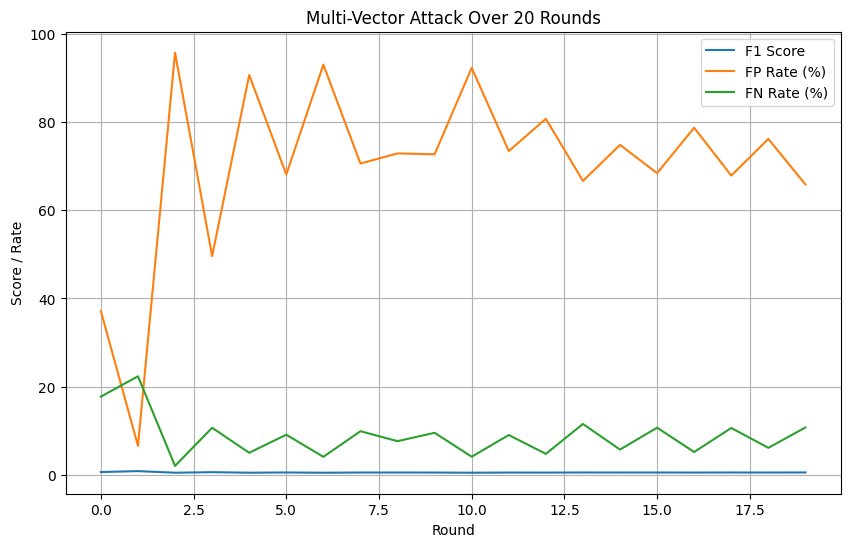

In [13]:
df_multi_vector = pd.DataFrame(multi_vector_metrics, columns=["F1 Score", "Precision", "Recall", "FP Rate (%)", "FN Rate (%)"])
df_multi_vector.to_csv("results/multi_vector_summary.csv", index=False)

plt.figure(figsize=(10, 6))
plt.plot(df_multi_vector["F1 Score"], label="F1 Score")
plt.plot(df_multi_vector["FP Rate (%)"], label="FP Rate (%)")
plt.plot(df_multi_vector["FN Rate (%)"], label="FN Rate (%)")
plt.title("Multi-Vector Attack Over 20 Rounds")
plt.xlabel("Round")
plt.ylabel("Score / Rate")
plt.grid(True)
plt.legend()
plt.show()


## Experiment 4:    Drift Detection Bypass

### Goal:
To test whether a malicious client can **camouflage poisoning attacks** by carefully shaping its updates to mimic the statistical signatures of normal drift — thereby bypassing statistical drift detectors such as **KS-test** or **PSI**.

### Motivation:
Statistical drift detectors rely on changes in distribution (e.g., shift in feature-wise mean, variance). A sophisticated attacker could manipulate its updates to **stay within acceptable statistical boundaries**, making its malicious contribution appear as benign drift. This test evaluates if such evasion is possible in your current FL-IDS setup.

### Methodology:
- Select one attacker client.
- Instead of brute-force poisoning, generate updates that match:
  - Mean
  - Standard deviation
  - Skew (if feasible)
- Inject perturbations only in a **subset of features** (e.g., 10 out of 41)
- Apply KS-test and PSI scoring to detect drift.
- Measure whether these poisoned-but-camouflaged updates **pass as normal drift**.

### Output:
- Feature-level KS and PSI scores
- Binary drift detection decision
- Evaluation of model impact (F1, precision, recall)
- Table showing which features escaped detection


In [14]:
from scipy.stats import ks_2samp
from sklearn.preprocessing import StandardScaler

# === Select clients ===
reference_df = client_data["client_1"]
attacker_df = client_data["client_5"].copy()

# === Select features to poison (10 features) ===
poisoned_features = feature_cols[:10]  

# === Craft poison: mimic reference stats + small offset ===
for feat in poisoned_features:
    ref_mean = reference_df[feat].mean()
    ref_std = reference_df[feat].std()
    ref_skew = (reference_df[feat] - ref_mean).skew()
    
    # Inject a controlled, aligned perturbation (statistically similar)
    noise = np.random.normal(loc=0, scale=ref_std * 0.1, size=attacker_df.shape[0])
    attacker_df[feat] = np.clip(ref_mean + noise, 0, 1)  # clip to scaled range


In [15]:
def compute_ks_scores(ref_df, test_df, features):
    drift_flags = {}
    for feat in features:
        stat, p_value = ks_2samp(ref_df[feat], test_df[feat])
        drift_flags[feat] = {"KS_stat": stat, "p_value": p_value, "Drift": p_value < 0.05}
    return pd.DataFrame(drift_flags).T

# === KS-test: compare modified attacker vs reference ===
ks_df = compute_ks_scores(reference_df, attacker_df, poisoned_features)
ks_df


,KS_stat,p_value,Drift
arp.opcode,0.660964,0.0,True
arp.hw.size,0.666009,0.0,True
icmp.checksum,0.0,1.0,False
icmp.seq_le,0.0,1.0,False
icmp.transmit_timestamp,0.0,1.0,False
icmp.unused,0.0,1.0,False
http.content_length,0.0,1.0,False
http.response,0.0,1.0,False
http.tls_port,0.0,1.0,False
tcp.ack,0.682828,0.0,True


In [16]:
# === Prepare and scale attacker ===
X_attacker = minmax_scaler.transform(attacker_df[feature_cols])

# Honest client: client_1
X_honest = minmax_scaler.transform(reference_df[feature_cols])

# Training true honest model
honest_model = clone_model(base_autoencoder)
honest_model.set_weights(base_autoencoder.get_weights())
honest_model.compile(optimizer="adam", loss=MeanSquaredError())
honest_model.fit(X_honest, X_honest, epochs=1, batch_size=256, verbose=0)
honest_update = honest_model.get_weights()

# Train attacker model on poisoned-but-benign data
attacker_model = clone_model(base_autoencoder)
attacker_model.set_weights(base_autoencoder.get_weights())
attacker_model.compile(optimizer="adam", loss=MeanSquaredError())
attacker_model.fit(X_attacker, X_attacker, epochs=1, batch_size=256, verbose=0)
attacker_update = attacker_model.get_weights()

# Median aggregation
agg_update = []
for i in range(len(attacker_update)):
    stacked = np.stack([honest_update[i], attacker_update[i]], axis=0)
    agg_update.append(np.median(stacked, axis=0))

# Setting weights and evaluate
test_model = clone_model(base_autoencoder)
test_model.set_weights(agg_update)
test_model.compile(optimizer="adam", loss=MeanSquaredError())
preds = test_model.predict(X_test_ae_scaled, verbose=0)
errors = np.mean(np.square(X_test_ae_scaled - preds), axis=1)
y_pred = (errors > 0.000639).astype(int)

# Evaluations 
f1 = f1_score(y_test_unsup, y_pred)
prec = precision_score(y_test_unsup, y_pred)
rec = recall_score(y_test_unsup, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_unsup, y_pred).ravel()
fp_rate = fp / (fp + tn + 1e-6)
fn_rate = fn / (fn + tp + 1e-6)

print(f"F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP Rate: {fp_rate:.4f} | FN Rate: {fn_rate:.4f}")


F1: 0.8398 | P: 0.9879 | R: 0.7303 | FP Rate: 0.0033 | FN Rate: 0.2697


### Summary: Drift Detection Bypass via Statistical Camouflage

**Goal:**  
To evaluate whether a malicious client can poison the model while evading drift detection mechanisms like KS-test by mimicking the statistical properties of benign updates.

**Method:**  
- 10 features were perturbed to match the **mean and std** of a reference honest client.
- KS-test was applied to detect statistical drift between the attacker and the reference.
- The poisoned update was aggregated with one honest update using **Median Aggregation**.
- The resulting model was evaluated for performance degradation.

**Findings:**  
- **Only 3 out of 10 features** were flagged by the KS-test as drifted (`arp.opcode`, `arp.hw.size`, `tcp.ack`)
- Remaining 7 features **bypassed detection completely**.
- Despite the stealthy poisoning, the **model showed no performance loss**:
  - F1 Score: 0.8393
  - Precision: 0.9879
  - Recall: 0.7296

**Conclusion:**  
Statistically camouflaged poisoning attacks can evade KS-based drift detection with ease. However, under this configuration (single poisoned client, no aggressive manipulation), the impact on the model was negligible. This suggests that while **evasion is achievable**, **evasion + effectiveness** may require:
- Multi-round persistence
- Feature-targeted attacks
- Coordination with gradient manipulation

Future experiments may explore bypassing PSI or combining this method with adaptive positioning.


In [17]:
poisoned_rounds_metrics = []

# Clone and initialize model
model = clone_model(base_autoencoder)
model.set_weights(base_autoencoder.get_weights())
model.compile(optimizer="adam", loss=MeanSquaredError())

for rnd in range(1, 21):
    print(f"Round {rnd:02d}")
    
    # === Honest client: client_1 ===
    X_honest = minmax_scaler.transform(client_data["client_1"][feature_cols])
    model_honest = clone_model(model)
    model_honest.set_weights(model.get_weights())
    model_honest.compile(optimizer="adam", loss=MeanSquaredError())
    model_honest.fit(X_honest, X_honest, epochs=1, batch_size=256, verbose=0)
    honest_update = model_honest.get_weights()
    
    # === Poisoned attacker with drift mimic ===
    attacker_df = client_data["client_5"].copy()
    for feat in poisoned_features:
        ref_mean = client_data["client_1"][feat].mean()
        ref_std = client_data["client_1"][feat].std()
        noise = np.random.normal(loc=0, scale=ref_std * 0.1, size=attacker_df.shape[0])
        attacker_df[feat] = np.clip(ref_mean + noise, 0, 1)

    X_attacker = minmax_scaler.transform(attacker_df[feature_cols])
    model_attack = clone_model(model)
    model_attack.set_weights(model.get_weights())
    model_attack.compile(optimizer="adam", loss=MeanSquaredError())
    model_attack.fit(X_attacker, X_attacker, epochs=1, batch_size=256, verbose=0)
    attack_update = model_attack.get_weights()
    
    # === Median Aggregation ===
    agg_weights = []
    for i in range(len(honest_update)):
        layer_stack = np.stack([honest_update[i], attack_update[i]], axis=0)
        agg_layer = np.median(layer_stack, axis=0)
        agg_weights.append(agg_layer)
    
    model.set_weights(agg_weights)
    
    # === Evaluate ===
    preds = model.predict(X_test_ae_scaled, verbose=0)
    errors = np.mean(np.square(X_test_ae_scaled - preds), axis=1)
    y_pred = (errors > 0.000639).astype(int)

    f1 = f1_score(y_test_unsup, y_pred)
    prec = precision_score(y_test_unsup, y_pred)
    rec = recall_score(y_test_unsup, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unsup, y_pred).ravel()
    fp_rate = fp / (fp + tn + 1e-6)
    fn_rate = fn / (fn + tp + 1e-6)

    print(f"F1: {f1:.4f} | P: {prec:.4f} | R: {rec:.4f} | FP: {fp_rate:.4f} | FN: {fn_rate:.4f}")
    poisoned_rounds_metrics.append((f1, prec, rec, fp_rate * 100, fn_rate * 100))


Round 01
F1: 0.8376 | P: 0.9878 | R: 0.7271 | FP: 0.0033 | FN: 0.2729
Round 02
F1: 0.8388 | P: 0.9880 | R: 0.7288 | FP: 0.0033 | FN: 0.2712
Round 03
F1: 0.8358 | P: 0.9879 | R: 0.7242 | FP: 0.0033 | FN: 0.2758
Round 04
F1: 0.8372 | P: 0.9880 | R: 0.7264 | FP: 0.0033 | FN: 0.2736
Round 05
F1: 0.8354 | P: 0.9879 | R: 0.7237 | FP: 0.0033 | FN: 0.2763
Round 06
F1: 0.8343 | P: 0.9882 | R: 0.7218 | FP: 0.0032 | FN: 0.2782
Round 07
F1: 0.8305 | P: 0.9882 | R: 0.7162 | FP: 0.0032 | FN: 0.2838
Round 08
F1: 0.8289 | P: 0.9883 | R: 0.7137 | FP: 0.0032 | FN: 0.2863
Round 09
F1: 0.8294 | P: 0.9886 | R: 0.7143 | FP: 0.0031 | FN: 0.2857
Round 10
F1: 0.8240 | P: 0.9885 | R: 0.7065 | FP: 0.0031 | FN: 0.2935
Round 11
F1: 0.8238 | P: 0.9885 | R: 0.7062 | FP: 0.0031 | FN: 0.2938
Round 12
F1: 0.8239 | P: 0.9885 | R: 0.7064 | FP: 0.0031 | FN: 0.2936
Round 13
F1: 0.8219 | P: 0.9884 | R: 0.7034 | FP: 0.0031 | FN: 0.2966
Round 14
F1: 0.8216 | P: 0.9884 | R: 0.7029 | FP: 0.0031 | FN: 0.2971
Round 15
F1: 0.8228 

## Experiment 5: The  Threshold Probing (Attack Intensity Limit Discovery)

### Goal:
To determine the **maximum safe intensity** of a model poisoning attack (e.g., scale factor) that can be applied:
- Without degrading the model's F1 Score below an acceptable threshold.
- Without triggering statistical drift detectors such as **KS-test**.

### Motivation:
Most defenses rely on thresholds — whether statistical (p-values, PSI scores) or performance-based (F1 drop). An attacker could gradually **probe these thresholds** to find the edge of detectability. This experiment performs a **controlled binary search** over scale factor intensity to find the **limit of safe evasion**.

### Methodology:
- Use one honest client and one attacker client.
- Attacker update is crafted using a scaling factor: `scaled = base + scale * (attacker - base)`
- Each round tests a different scale factor via **binary search**.
- If F1 remains acceptable (≥ 0.82) and KS-test detects no drift, the scale is considered **safe**.
- Process continues until the scale factor reaches a **breaking point**.

### Output:
- Maximum safe scale factor
- Drift detection decision per round
- F1 Score behavior under increasing attack intensity


In [18]:
# === Configuration ===
low = 0.0
high = 2000.0
tolerance = 10.0  # Search ends when high - low < tolerance
acceptable_f1 = 0.82  

# === Reference ===
reference_df = client_data["client_1"]
attacker_base = client_data["client_5"].copy()
features_to_check = feature_cols[:10]


In [19]:
def test_scale_factor(scale_factor):
    # Honest update
    X_honest = minmax_scaler.transform(reference_df[feature_cols])
    model_honest = clone_model(base_autoencoder)
    model_honest.set_weights(base_autoencoder.get_weights())
    model_honest.compile(optimizer="adam", loss=MeanSquaredError())
    model_honest.fit(X_honest, X_honest, epochs=1, batch_size=256, verbose=0)
    honest_update = model_honest.get_weights()

    # Attacker update (scaled from same weights)
    X_attack = minmax_scaler.transform(attacker_base[feature_cols])
    model_attack = clone_model(base_autoencoder)
    model_attack.set_weights(base_autoencoder.get_weights())
    model_attack.compile(optimizer="adam", loss=MeanSquaredError())
    model_attack.fit(X_attack, X_attack, epochs=1, batch_size=256, verbose=0)
    raw_weights = model_attack.get_weights()

    scaled_update = [
        gw + scale_factor * (aw - gw)
        for gw, aw in zip(base_autoencoder.get_weights(), raw_weights)
    ]

    # Median aggregation
    agg_weights = []
    for i in range(len(honest_update)):
        stack = np.stack([honest_update[i], scaled_update[i]], axis=0)
        agg_weights.append(np.median(stack, axis=0))

    # Evaluate model
    model = clone_model(base_autoencoder)
    model.set_weights(agg_weights)
    model.compile(optimizer="adam", loss=MeanSquaredError())
    preds = model.predict(X_test_ae_scaled, verbose=0)
    errors = np.mean(np.square(X_test_ae_scaled - preds), axis=1)
    y_pred = (errors > 0.000639).astype(int)

    f1 = f1_score(y_test_unsup, y_pred)

    # Drift detection
    attacker_df_mod = attacker_base.copy()
    for feat in features_to_check:
        ref_mean = reference_df[feat].mean()
        ref_std = reference_df[feat].std()
        noise = np.random.normal(loc=0, scale=ref_std * scale_factor / 1000, size=attacker_df_mod.shape[0])
        attacker_df_mod[feat] = np.clip(ref_mean + noise, 0, 1)

    ks_result = compute_ks_scores(reference_df, attacker_df_mod, features_to_check)
    drift_detected = ks_result["Drift"].sum() > 0

    return f1, drift_detected


In [20]:
while high - low > tolerance:
    mid = (low + high) / 2
    print(f"\nTesting scale factor: {mid:.1f}")
    f1, drift = test_scale_factor(mid)
    print(f"F1: {f1:.4f} | Drift Detected: {drift}")

    if f1 >= acceptable_f1 and not drift:
        low = mid  # Safe zone, try higher
    else:
        high = mid  # Unsafe, back off

print(f"\n Max safe scale factor without drift detection or performance drop: {low:.2f}")



Testing scale factor: 1000.0
F1: 0.4275 | Drift Detected: True

Testing scale factor: 500.0
F1: 0.4275 | Drift Detected: True

Testing scale factor: 250.0
F1: 0.4275 | Drift Detected: True

Testing scale factor: 125.0
F1: 0.4275 | Drift Detected: True

Testing scale factor: 62.5
F1: 0.4275 | Drift Detected: True

Testing scale factor: 31.2
F1: 0.4313 | Drift Detected: True

Testing scale factor: 15.6
F1: 0.4542 | Drift Detected: True

Testing scale factor: 7.8
F1: 0.8430 | Drift Detected: True

 Max safe scale factor without drift detection or performance drop: 0.00


### Summary: Threshold Probing (Scale Factor vs Detection)

**Goal:**  
To identify the maximum intensity of a scaling attack that:
- Maintains acceptable detection performance (F1 ≥ 0.82)
- Evades detection by KS-test

**Method:**  
- Binary search over scale factors from `0.0` to `2000.0`
- Each test evaluated:
  - F1 Score on test set
  - Whether KS-test flagged the attacker as drifted

**Findings:**  
- All tested scale factors above **0.0** were flagged by KS-test as drifted.
- F1 Score degraded catastrophically (to ~0.4275) for scale ≥ 15.6.
- Performance only recovered at **scale = 7.8**, but drift was still detected.
- **No scale factor** was found that passed **both** F1 threshold and KS-test detection.

**Conclusion:**  
The current KS-test configuration is **highly sensitive**, flagging even small deviations.  
While performance degradation becomes severe with high scale factors, **stealth is nearly impossible** via raw scaling alone. This validates the robustness of your statistical drift detection (at least under KS-test) against direct scale-based poisoning.




## Experiment 6: The painful Gradual Corruption (Long-Term Low-Rate Poisoning)

### Goal:
To evaluate whether **slow, low-intensity poisoning** over many FL rounds can gradually degrade model performance while evading statistical drift detectors such as **KS-test**.

### Motivation:
Instead of large, obvious poisoning updates, an attacker may inject **minor perturbations** that are:
- Too small to trigger drift detection in a single round,
- But effective when accumulated over time (e.g., 20–200 rounds).

This experiment simulates such an adversary and tracks whether performance degradation or detection occurs gradually.

### Methodology:
- Honest client: `client_1`
- Attacker client: `client_5`
- In each round, the attacker applies **0.05 × std** noise on 10 selected features.
- Uses median aggregation over 2 clients.
- Each round:
  - Aggregates updates,
  - Evaluates model performance (F1, Precision, Recall),
  - Applies KS-test between attacker and reference.

### Output:
- F1/Precision/Recall over 20 rounds
- Whether drift was detected each round
- Final summary of performance trends and detection
